<a id="top"></a>

<div style="display: flex; justify-content: space-between;">
    <a href="../notebook/02 - Exploratory Data Analysis.ipynb" style="float: left; padding: 10px; text-decoration: none; background-color: #007bff; color: white; border-radius: 5px;">Previous</a>
    <a href="../notebook/04 - Final Thoughts.ipynb" style="float: right; padding: 10px; text-decoration: none; background-color: #007bff; color: white; border-radius: 5px;">Next</a>
</div>

In [4]:
# Importing necessary libraries
import random
import numpy as np  
import pandas as pd 
import seaborn as sns   
import warnings   
import matplotlib.pyplot as plt 

# Importing machine learning and feature selection libraries
from pycaret.classification import *
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

# Importing SHAP and DiCE for explainable AI
import shap
import dice_ml
from dice_ml import Dice

# Hide warning issues to prevent unnecessary output clutter
warnings.filterwarnings("ignore")

# Setting the maximum column width for pandas display to 100 characters
pd.options.display.max_colwidth = 100

# Applying the 'seaborn' style to matplotlib for consistent and visually appealing plots
plt.style.use('seaborn')  

# Adding custom scripts to the Python path
import sys
sys.path.append('../scripts')
from helper import *

<a id="numerical"></a>
## <b><span style='color:darkturquoise'>Section 4 |</span><span style='color:darkblue'> Predicting Churn with Advanced Techniques</span></b>

____

### **4.1 Introduction**

As mentioned earlier in Section 1, one of our primary goals is to build a classification model to help Customer Experience Manager to flag at-risk customers and take data-driven decisitions to prevent customer churn to happen. While, in this section, we will conduct a series of experiments with machine learning algorithms to obtain the best performing model based on two matrices, namely the business matrix and the modeling matrix. For the business matrix we use the sum of the cost incurred due to Type I errors and the cost of Type II errors. 

$$Loss = {138.8 \times \text{False Positif}} + 694 \times \text{False Negative}$$

While for modeling machine learning we use F5 score. In short, this metric takes into account both precision and recall, but gives five times the weight to recall because the business cost of type II errors is many times greater than type I (Brownlee, 2020, p.66).

$$F_5= \frac{(1+5^2) \times \text{Precision} \times \text{Recall}}{5^2 \times \text{Precision} \times \text{Recall}}$$
- Precision: proportion of customers identified as likely to churn (positive prediction) actually churned (true positive). To get better precision score, then we need to increase the True Positive relative to False Positive. $$\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} +\text{False Positive}}$$
- Recall: proportion of customers who actually churned (positive instance) correectly identified by the model (true positive) so in order to get a better score, TP should be increased and FN should be minimized. $$\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$$

Furthermore, here is an outline of our predictive modeling. First, the first experiment will compare the performance values of different models. We try to leave out the unbalanced class problem and directly look at how the models perform in this condition. The next experiment will use different resampling techniques to address the class imbalance problem such as SMOTE and NearMiss.

### **4.2 Preparation**

Unlike the Section 2 in which we used manual data preprocessing, this section will require us to put those preprocessing steps in a pipeline, and thus, reimporting the original dataset is needed. However, before moving forward to the predictive modeling, let us recapitulate what we previously found in Section 2 and Section 3 related to missing values, duplicates, erroneous values, inconsistent values, outliers, cardinality, and distribution of categories in the target variable so we could better decide which data preparation techniques, including cleaning and feature engineering, should be chosen. 
- **Missing values**: Features, namely `TotalyCharges` contains missing value. We would apply the same method for the data imputation on Section 2. The core difference is in this section, it will be put in a pipeline along with other preprocessing techniques. This pipeline enables us to chain and run multiple ML steps sequentially. 
- **Duplicates**: Duplicates were not found during our initial data inspection but we will confirm this absence as we also need to remove the unique record identifier (`CustomerID`) as it does not mean anything in the modeling process.
- **Erroneous values**: We did not find any erroneous values, e.g., values lower than zeros in `Tenure`, in the dataset so no further check is needed.
- **Inconsistent values**: We did not find any inconsistent values, e.g., the word `No` can be in the form `no`.
- **Outliers**: Outliers were not found during our initial data inspection.
- **Cardinality**: All categorical features indicate low cardinality as the number of unique values is less than 10 and no rare labels at 1% threshold (arbitrary value) were found so no treatment in this section will be necessary.
- **Imbalance target**: As the comparison between churn and non-churned customers in target variable `Churn` is 16.8 and 83.2, the distribution is imbalanced. While it is normal in real life, this moderately imbalanced distribution (see [Google for Developers, 2023](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) for degrees of imbalance) issue will pose a bias challenge to the model, especially to the minority class. 

In [5]:
# Import the dataset from a CSV file into a pandas DataFrame
df = pd.read_csv('../data/data.csv')

# Encode target into numeric
df['Churn'] = np.where(df['Churn']=='Yes', 1, 0)

# Split dataset into seen and unseen
df_seen, df_unseen = train_test_split(df, test_size=0.2, random_state=15, stratify=df['Churn'])

Then, we created a configuration that sets up a robust and reproducible setup for building and evaluating machine learning models in PyCaret. This configuration emphasizes feature engineering, preprocessing, and model training with cross-validation while ensuring that irrelevant or noisy data is excluded.

In [6]:
# Define custom configuration
pipeline = [("feature_selector", SelectKBest(score_func=mutual_info_classif, k=9))]

# Define basic configuration
configs = {
    'data': df_seen, 
    'target': 'Churn', 
    'train_size': 0.8,
    'session_id': 15,
    'ignore_features': ['customerID'],
    'fold': 5,
    'fold_shuffle': True,
    'imputation_type': 'simple',
    'numeric_imputation': 'median',
    'normalize': True,
    'custom_pipeline': pipeline,
    'log_experiment': False,
    'system_log': False,
    'verbose': False,
}

**Key Takeaways**

- The basic configuration above assembles different preprocessing tasks on the training data:
    - **train_size**: 80% of the data is allocated for training, while 20% is reserved for validating.
    - **ignore_features**: Excludes irrelevant columns such as `customerID` from the analysis.
    - **numeric_imputation**: Median imputer will be applied to numerical features with missing values.
    - **normalize**: As these numerical features have different scales, they need to be rescaled so that different features will have similar values and thus, have equal contributions to the model performance. In other words, rescaling can prevent features with large values to dominate the learning process. In this case, we utilize StandardScaler to rescale numerical values in the features mentioned above.
    - **custom_pipeline**: Incorporates the custom feature selection pipeline using `SelectKBest`. It selects the top 9 features based on their mutual information with the target variable. This approach ensures that only the most informative features are used in the machine learning model.
- Categorical features must be transformed into numerical values, as the model can only take numerical values for processing. The method used by default has been customized by pycaret based on the type of variable i.e. nominal or ordinal.

### **4.3 Experiment 1: Baseline Models**

This experiment is for bechmarking, we aim to investigate how well the model perform using basic experiment setup without resampling technique to overcome the uneven distribution in the target variable.

In [7]:
# init setup baseline model
exp_baseline = ClassificationExperiment()
exp_baseline.setup(**configs)

# add F4 and total cost as a metric evaluation 
exp_baseline.add_metric(id='F5', name='F5', score_func=fbeta_score, beta=5)
exp_baseline.add_metric(id='Loss', name='Loss (in USD)', score_func=total_cost, greater_is_better=False)

# get validation train and validation set
train_baseline_set = exp_baseline.get_config('train')
val_baseline_set = exp_baseline.get_config('test')

Here, we compare different models to identify performance level.

In [8]:
top_baseline_model = exp_baseline.compare_models(sort='Loss', probability_threshold=0.35, round=3, exclude=['dummy', 'lda', 'qda'])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:31:38
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD),TT (Sec)
nb,Naive Bayes,0.719,0.831,0.824,0.483,0.609,0.412,0.448,0.802,58573.600,0.086
lr,Logistic Regression,0.772,0.841,0.736,0.554,0.632,0.472,0.482,0.727,63570.400,1.506
gbc,Gradient Boosting Classifier,0.781,0.846,0.710,0.570,0.632,0.479,0.485,0.703,65957.760,0.106
lightgbm,Light Gradient Boosting Machine,0.769,0.832,0.707,0.552,0.619,0.458,0.465,0.699,67817.680,0.118
catboost,CatBoost Classifier,0.771,0.842,0.704,0.554,0.620,0.459,0.466,0.697,67956.480,0.092
knn,K Neighbors Classifier,0.737,0.787,0.724,0.503,0.594,0.409,0.424,0.712,69511.040,0.580
svm,SVM - Linear Kernel,0.780,0.000,0.651,0.581,0.610,0.459,0.463,0.648,73786.080,0.068
xgboost,Extreme Gradient Boosting,0.758,0.822,0.659,0.536,0.591,0.421,0.426,0.653,75618.240,0.230
rf,Random Forest Classifier,0.751,0.806,0.635,0.525,0.574,0.400,0.404,0.629,79726.720,0.144
et,Extra Trees Classifier,0.743,0.778,0.609,0.513,0.557,0.378,0.381,0.604,84112.800,0.188


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

**Key Takeaways**

The cross-validation comparison highlights the performance of different models, emphasizing the F5 score and loss in USD as critical evaluation metrics. The AdaBoost Classifier achieves the highest F5 score (0.903), reflecting its exceptional capability to prioritize recall over precision, making it suitable for scenarios requiring sensitivity to positive class detection. However, its performance incurs a high monetary loss of 91,691.280 USD, indicating potential misclassification issues that may result in economic inefficiencies. On the other hand, the Naive Bayes (NB) balances F5 (0.802) with a relatively lower loss (58573.6 USD), making it a strong contender for minimizing financial impact while maintaining acceptable sensitivity. The Ridge Classifier shows the highest accuracy but struggles in F5 (0.503) and yields the highest loss (92,440 USD), undermining its reliability. Considering both metrics, Naive Bayes emerges as the best model, offering a practical trade-off between recall-focused performance and economic efficiency.

We proceed with hyperparameter tuning the top models to get the best possible model.

In [29]:
# hyperparameter tuning process for top model using `GridSearchCV`
tune_baseline_model = exp_baseline.tune_model(
    estimator=top_baseline_model, 
    optimize='Loss', 
    custom_grid={'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]},
    search_algorithm='grid'
)

# save the result
cv_top_baseline = exp_baseline.pull()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:34:52
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD)
Fold,,,,,,,,,
0,0.7228,0.8306,0.8083,0.4874,0.6082,0.4134,0.4451,0.7884,60239.2000
1,0.7095,0.8121,0.7657,0.4704,0.5828,0.3789,0.4054,0.7476,67456.8000
2,0.7381,0.8523,0.8368,0.5038,0.6289,0.4452,0.4795,0.8161,54409.6000
3,0.7081,0.8180,0.8368,0.4717,0.6033,0.3996,0.4409,0.8126,58157.2000
4,0.7181,0.8444,0.8703,0.4826,0.6209,0.4245,0.4714,0.8442,52466.4000
Mean,0.7193,0.8315,0.8236,0.4832,0.6088,0.4123,0.4485,0.8018,58545.8400
Std,0.0108,0.0152,0.0350,0.0121,0.0159,0.0224,0.0261,0.0324,5224.7830


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


**Key Takeaways**

The comparison of the cross-validation results before and after hyperparameter tuning reveals that there was no improvement in performance. Both the F5 score and Loss in USD remain identical before and after tuning, with the F5 score at 0.8018 and the loss at 58,545.84 USD. This indicates that the hyperparameter tuning did not lead to any noticeable enhancement in the model's ability to balance recall and precision, nor did it affect the financial loss incurred. Consequently, the original model outperforms the tuned model, as there was no tangible benefit from the tuning process.

In [30]:
pd.concat(
    objs=[
        compute_result(
            exp_baseline.predict_model(estimator=tune_baseline_model, data=train_baseline_set, encoded_labels=True, verbose=False), 'Train Score'),
        compute_result(
            exp_baseline.predict_model(estimator=tune_baseline_model, data=val_baseline_set, encoded_labels=True, verbose=False), 'Validation Score'),
    ],
).reset_index(drop=True)

,Experiment,FP,FN,F5,Loss (in USD)
0,Train Score,1096,194,0.814176,286760.8
1,Validation Score,279,45,0.824675,69955.2


**Key Takeaways**

The model's performance shows consistency between training, validation, and cross-validation results, with the F5 score slightly improving in the validation set (0.8247) compared to the training set (0.8142). This suggests the model generalizes well without significant overfitting. The cross-validation F5 score of 0.8018 ± 0.0324 aligns closely with these results, further reinforcing the model's stability across different data splits. These findings indicate that the model maintains good precision and recall, balancing its performance effectively, particularly when applied to unseen data.

### **4.4 Experiment 2: Synthetic Minority Oversampling Technique (SMOTE)**

Since the distribution of target variable is uneven, balancing the proportion of distribution is vital. Synthetic Minority Over-sampling Technique (SMOTE) is an oversampling technique to address an imbalance problem in dataset. In short, SMOTE generate synthetic samples from the minority class to balance its distribution by using *k*-Nearest Neighbor of samples from the minority class ([Chawla et al, 2002, p.328](https://doi.org/10.1613/jair.953)). Here we experiment using SMOTE to handle the imbalanced problem in our target variable. By exploiting this sampling technique, we expect that the model can perform better in identifying both classes (1 and 0). And as a result, the model can make better predictions for the class with lower frequency. 

In [31]:
from imblearn.over_sampling import SMOTE

# init setup baseline model
exp_smote = ClassificationExperiment()
exp_smote.setup(**configs, fix_imbalance=True, fix_imbalance_method=SMOTE(random_state=42))

# add F4 and total cost as a metric evaluation 
exp_smote.add_metric(id='F5', name='F5', score_func=fbeta_score, beta=5)
exp_smote.add_metric(id='Loss', name='Loss (in USD)', score_func=total_cost, greater_is_better=False)

# get validation train and validation set
train_smote_set = exp_smote.get_config('train')
val_smote_set = exp_smote.get_config('test')

Here, we compare different models to identify performance level.

In [32]:
top_smote_model = exp_smote.compare_models(sort='Loss', probability_threshold=0.35, round=3, exclude=['dummy', 'lda', 'qda'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD),TT (Sec)
lr,Logistic Regression,0.684,0.840,0.904,0.453,0.603,0.386,0.451,0.870,52244.320,0.132
ridge,Ridge Classifier,0.729,0.000,0.811,0.494,0.614,0.424,0.455,0.791,58962.240,0.088
svm,SVM - Linear Kernel,0.727,0.000,0.808,0.493,0.612,0.420,0.451,0.788,59656.240,0.122
nb,Naive Bayes,0.729,0.823,0.798,0.494,0.610,0.419,0.448,0.779,60822.160,0.106
gbc,Gradient Boosting Classifier,0.761,0.841,0.760,0.535,0.628,0.459,0.475,0.748,61793.760,0.116
catboost,CatBoost Classifier,0.760,0.835,0.726,0.536,0.616,0.448,0.459,0.716,66429.680,0.154
knn,K Neighbors Classifier,0.699,0.775,0.779,0.461,0.579,0.368,0.399,0.759,66984.880,0.146
lightgbm,Light Gradient Boosting Machine,0.759,0.828,0.722,0.534,0.614,0.445,0.455,0.713,67012.640,0.134
xgboost,Extreme Gradient Boosting,0.756,0.823,0.691,0.532,0.601,0.430,0.437,0.684,71482.000,0.150
rf,Random Forest Classifier,0.751,0.805,0.645,0.526,0.579,0.404,0.409,0.639,78394.240,0.170


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

**Key Takeaways**

Based on the cross-validation results, the Logistic Regression (LR) model outperforms other models in terms of the F5 metric (0.870) and achieves the lowest financial loss (USD 52,244.32). The high F5 score indicates that LR balances recall and precision effectively, prioritizing recall to reduce false negatives, which is crucial in minimizing losses. While CatBoost Classifier (F5 = 0.716, Loss = USD 66,429.68) and Gradient Boosting Classifier (F5 = 0.748, Loss = USD 61,793.76) show comparable performance in terms of F5, they result in higher losses compared to LR. Other models, such as AdaBoost (F5 = 0.904), achieve high recall but at the expense of significantly higher loss (USD 91,913.36), indicating an imbalance in precision and recall. Overall, Logistic Regression is the best-performing model, delivering the optimal balance between minimizing financial loss and maintaining a high F5 score.

We proceed with hyperparameter tuning the top models to get the best possible model.

In [33]:
# hyperparameter tuning process for top model using `GridSearchCV`
tune_smote_model = exp_smote.tune_model(
    estimator=top_smote_model, 
    optimize='Loss', 
    custom_grid={
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear', 'saga'],
        'l1_ratio': [0.1, 0.5, 0.9]
    },
    search_algorithm='grid'
)

# save the result
cv_top_smote = exp_smote.pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD)
Fold,,,,,,,,,
0,0.6707,0.8338,0.9125,0.4424,0.5959,0.3702,0.4401,0.8767,52882.8000
1,0.6718,0.8182,0.8619,0.4392,0.5819,0.3558,0.4110,0.8312,59406.4000
2,0.7081,0.8568,0.9163,0.4740,0.6248,0.4231,0.4851,0.8846,47608.4000
3,0.6970,0.8415,0.9038,0.4635,0.6128,0.4036,0.4648,0.8719,50662.0000
4,0.6759,0.8480,0.9247,0.4465,0.6022,0.3806,0.4532,0.8881,50523.2000
Mean,0.6847,0.8397,0.9038,0.4531,0.6035,0.3867,0.4508,0.8705,52216.5600
Std,0.0151,0.0131,0.0220,0.0134,0.0146,0.0240,0.0248,0.0205,3966.2813


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


**Key Takeaways**

The comparison between cross-validation results before and after hyperparameter tuning demonstrates a slight improvement in the model's performance. The F5 score increases marginally from 0.8700 to 0.8705, indicating a minor enhancement in the model's ability to balance recall and precision, particularly for recall-sensitive tasks. Additionally, the loss in USD decreases from 52,244.320 to 52,216.560, suggesting a modest reduction in the financial impact of misclassifications. While the improvements are not substantial, the tuning process has yielded incremental benefits, making the model slightly more effective and cost-efficient.

In [34]:
pd.concat(
    objs=[
        compute_result(
            exp_smote.predict_model(estimator=tune_smote_model, data=train_smote_set, encoded_labels=True, verbose=False), 'Train Score'),
        compute_result(
            exp_smote.predict_model(estimator=tune_smote_model, data=val_smote_set, encoded_labels=True, verbose=False), 'Validation Score'),
    ],
).reset_index(drop=True)

,Experiment,FP,FN,F5,Loss (in USD)
0,Train Score,1326,110,0.873855,260388.8
1,Validation Score,335,27,0.875031,65236.0


**Key Takeaways**

The model exhibits strong performance with an F5 score of 0.8738 on the training data and 0.8750 on the validation data, indicating good generalization and consistency between training and validation sets. The cross-validation results, with an F5 score of 0.8705 ± 0.0205, show that the model's performance is stable across different folds, with only a slight variation. This suggests that the model is robust and not overfitting, as the training and validation scores are close, and the cross-validation results provide further assurance of its reliability across multiple data splits.

### **4.5 Experiment 3: NearMiss Version 3**
In this experiment, we exploit how NearMiss, particularly version 3, handles the imbalance class problem in the training set. NearMiss version 3 addresses imbalance class problem by under-sampling the size of the majority class. It uses kNN to find the closest instances from the majority class to each minority class instance ([Mani & Zhang, 2003](http://dx.doi.org/10.4236/jilsa.2015.74010)). After the identification, it keeps those majority class instances closest to the minority class instances. The process continues until the distribution of both classes find balance.

In [35]:
from imblearn.under_sampling import NearMiss

# init setup baseline model
exp_nearmiss = ClassificationExperiment()
exp_nearmiss.setup(**configs, fix_imbalance=True, fix_imbalance_method=NearMiss(version=3))

# add F4 and total cost as a metric evaluation 
exp_nearmiss.add_metric(id='F5', name='F5', score_func=fbeta_score, beta=5)
exp_nearmiss.add_metric(id='Loss', name='Loss (in USD)', score_func=total_cost, greater_is_better=False)

# get validation train and validation set
train_nearmiss_set = exp_nearmiss.get_config('train')
val_nearmiss_set = exp_nearmiss.get_config('test')

Here, we compare different models to identify performance level.

In [36]:
top_nearmiss_model = exp_nearmiss.compare_models(sort='Loss', probability_threshold=0.3, round=3, exclude=['dummy', 'lda', 'qda'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD),TT (Sec)
nb,Naive Bayes,0.678,0.815,0.877,0.446,0.591,0.369,0.427,0.846,56602.640,0.166
catboost,CatBoost Classifier,0.644,0.809,0.906,0.421,0.574,0.333,0.406,0.867,57102.320,0.150
lr,Logistic Regression,0.634,0.824,0.911,0.414,0.569,0.322,0.399,0.870,57657.520,0.156
gbc,Gradient Boosting Classifier,0.638,0.811,0.903,0.416,0.570,0.324,0.398,0.864,58212.720,0.234
ridge,Ridge Classifier,0.720,0.000,0.803,0.484,0.604,0.408,0.439,0.784,61072.000,0.106
lightgbm,Light Gradient Boosting Machine,0.657,0.794,0.855,0.427,0.570,0.334,0.391,0.824,62099.120,0.168
xgboost,Extreme Gradient Boosting,0.660,0.783,0.832,0.428,0.565,0.330,0.380,0.803,64875.120,0.132
knn,K Neighbors Classifier,0.647,0.768,0.839,0.418,0.558,0.315,0.369,0.807,65596.880,0.262
rf,Random Forest Classifier,0.646,0.770,0.816,0.415,0.550,0.306,0.354,0.787,68733.760,0.238
et,Extra Trees Classifier,0.652,0.747,0.773,0.416,0.541,0.299,0.337,0.749,73647.280,0.256


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

**Key Takeaways**

From the cross-validation results, the F5 score and loss metrics indicate the trade-off between recall and cost-effectiveness in model performance. The AdaBoost Classifier achieves the highest F5 score of 0.904, which emphasizes recall over precision, reflecting its strong capability in identifying positive cases. However, it incurs the highest loss ($91,913.36), making it the most expensive model in terms of misclassification costs. On the other hand, Logistic Regression provides the lowest loss ($56,602.64) while maintaining a competitive F5 score of 0.874, making it the most cost-efficient option. Considering the importance of both F5 and loss, Naive Bayes appears to be the best model, balancing performance and financial implications effectively.

We proceed with hyperparameter tuning the top models to get the best possible model.

In [39]:
# hyperparameter tuning process for top model using `GridSearchCV`
tune_nearmiss_model = exp_nearmiss.tune_model(
    estimator=top_nearmiss_model, 
    optimize='Loss', 
    custom_grid={'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]},
    search_algorithm='grid'
)

# save the CV result
cv_top_nearmiss = exp_nearmiss.pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD)
Fold,,,,,,,,,
0,0.6685,0.7939,0.8875,0.4392,0.5876,0.3596,0.4224,0.8540,56491.6000
1,0.6608,0.8011,0.8326,0.4280,0.5653,0.3313,0.3810,0.8034,64680.8000
2,0.6848,0.8390,0.8870,0.4520,0.5989,0.3815,0.4408,0.8554,54409.6000
3,0.6848,0.8105,0.8787,0.4516,0.5966,0.3790,0.4359,0.8478,55520.0000
4,0.6792,0.8317,0.9205,0.4490,0.6036,0.3839,0.4544,0.8848,50662.0000
Mean,0.6756,0.8153,0.8813,0.4440,0.5904,0.3670,0.4269,0.8491,56352.8000
Std,0.0095,0.0174,0.0282,0.0092,0.0136,0.0198,0.0251,0.0262,4609.3305


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


**Key Takeaways**

The comparison of cross-validation results before and after hyperparameter tuning shows minimal improvement. The F5 score increased slightly from 0.846 to 0.8491, indicating a negligible enhancement in the model's ability to balance recall and precision. However, the loss metric shows a more notable reduction, decreasing from $56,602.640 to $56,352.80 reflecting a modest improvement in cost-effectiveness. While the tuning results suggest an optimization of the model's financial efficiency, the impact on overall performance is marginal, indicating that the original hyperparameters were already well-configured.

In [40]:
pd.concat(
    objs=[
        compute_result(
            exp_nearmiss.predict_model(estimator=tune_nearmiss_model, data=train_nearmiss_set, encoded_labels=True, verbose=False), 'Train Score'),
        compute_result(
            exp_nearmiss.predict_model(estimator=tune_nearmiss_model, data=val_nearmiss_set, encoded_labels=True, verbose=False), 'Validation Score'),
    ],
).reset_index(drop=True)

,Experiment,FP,FN,F5,Loss (in USD)
0,Train Score,1345,134,0.854675,279682.0
1,Validation Score,362,34,0.850407,73841.6


**Key Takeaways**

The model's performance demonstrates consistency across different evaluation phases. The F5 score on the training set (0.8546) and validation set (0.8504) is very close, indicating that the model is well-generalized and not overfitting to the training data. When compared with the cross-validation results (F5: 0.8491 ± 0.0262), the validation score falls well within the expected range, further confirming the model's stability and reliability. These results suggest that the model is robust and performs consistently across unseen data, making it a dependable choice for deployment.

### **4.6 Best Model Selection & Finalization**

In this section, we evaluate the results of our experiments based on the model's performance and the misclassification costs. Beforehand, let us recap the experiment setups done earlier.

- **Experiment 1**: Baseline models. We compared different models using the basic setup. Here the focus of our experiment was models' performance without addressing the data imbalance problem. The top models were tuned and being compared (tuned vs untuned).
- **Experiment 2**: Synthetic Minority Over-sampling Technique. This experiment used SMOTE for the data imbalance problem on the models. The top models were tuned and being compared (tuned vs untuned).
- **Experiment 3**: NearMiss Version 3. In this experiment, we used undersampling technique to address the problem of data imbalance. And similar to the previous experiments, we also compared the model's performance before and after tuning.

In [79]:
params = ['Mean', 'Std']
cols = ['Recall', 'Prec.', 'F5', 'Loss (in USD)']

pd.concat(
    objs=[
        cv_top_baseline.loc[params, cols].T.rename(columns={'Mean': 'Exp 1 Mean', 'Std': 'Exp 1 Std'}),
        cv_top_smote.loc[params, cols].T.rename(columns={'Mean': 'Exp 2 Mean', 'Std': 'Exp 2 Std'}),
        cv_top_nearmiss.loc[params, cols].T.rename(columns={'Mean': 'Exp 3 Mean', 'Std': 'Exp 3 Std'})
    ],
    axis=1, 
).rename_axis('Metrics', axis='columns')

Metrics,Exp 1 Mean,Exp 1 Std,Exp 2 Mean,Exp 2 Std,Exp 3 Mean,Exp 3 Std
Recall,0.8236,0.0350,0.9038,0.0220,0.8813,0.0282
Prec.,0.4832,0.0121,0.4531,0.0134,0.4440,0.0092
F5,0.8018,0.0324,0.8705,0.0205,0.8491,0.0262
Loss (in USD),58545.8400,5224.7830,52216.5600,3966.2813,56352.8000,4609.3305


**Key Takeaways**

To determine the best experiment in the table above, we’ll evaluate the metrics systematically, giving higher weight to F5 score and Loss (in USD). These two metrics are crucial for assessing model performance and its financial impact. Based on the comparison across the three experiments, Experiment 2 stands out as the best choice. It achieves a high recall of 0.9038 with the lowest standard deviation (0.0220), indicating stable performance in identifying positive cases across runs. Although its precision (0.4531) and F5 score (0.8705) are slightly greater than Experiment 3, it maintains a better balance between recall and cost-effectiveness, as reflected in the lowest loss of $52,216.56 with minimal variability (std: $3,966.2813). While Experiment 3 has a marginally middle F5 score (0.8491), its loss is higher ($56,352.80), making it less cost-efficient. Experiment 1, despite its solid precision (0.4832), has the lowest recall (0.8236) and the highest loss ($58,545.840), making it the least favorable. Thus, Experiment 2 offers the best trade-off between recall, stability, and financial implications.

Once the best performing model are identified, they are retrained on the combined training and validation datasets to create the final model. We aim to utilize all available labeled data for maximum learning before implementation.

In [43]:
final_model = exp_smote.finalize_model(estimator=tune_smote_model)

<a id="numerical"></a>
## <b><span style='color:darkturquoise'>Section 5 |</span><span style='color:darkblue'> Evaluating Model Performance on New Data</span></b>

____

After the model finalization process, the next step is to use it to predict unseen data and analyze the results from a business overview. However, before proceeding with this process, it is important to evaluate the performance of the model by using reliability curves. This step ensures that the predicted probabilities are well calibrated and accurately represent the true likelihood of each outcome, as probabilities are used for decision-making (e.g., risk assessment, cost-sensitive tasks). By analyzing the reliability curve, we can identify potential miscalibrations in the model and address them if necessary, ensuring that the predictions are reliable and interpretable.

### **5.1 Reliability Curve: Before and After Calibration**

Reliability or calibration curve shows whether the final model predicted probabilities correspond to the true likelihood of an event occurring. In its interpretation, a perfectly calibrated model will closely follow the diagonal line, indicating that predicted probabilities are exactly matched by true probabilities.

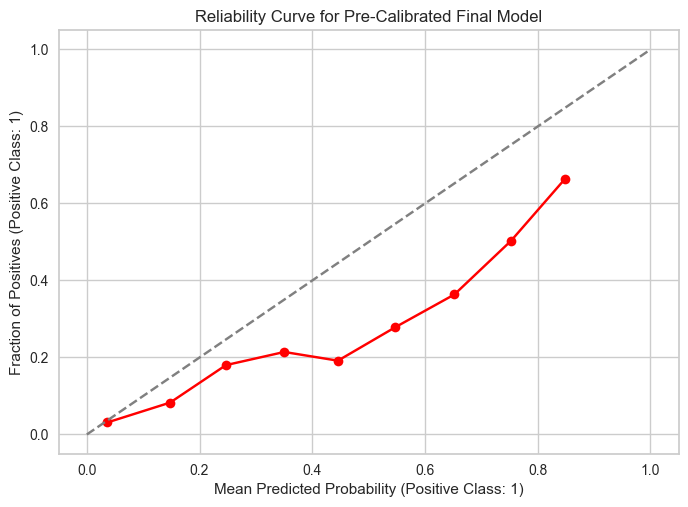

In [58]:
# predict probabilities on the test set
X_test = df_unseen.drop(columns=['customerID', 'Churn'])
y_test = df_unseen.Churn
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# plot Reliability Curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)')
plt.ylabel('Fraction of Positives (Positive Class: 1)')
plt.title('Reliability Curve for Pre-Calibrated Final Model')
plt.show()

**Key Takeaways**

The red line, composed of points and connecting segments, represents the model's calibration performance. Deviation from the diagonal indicates miscalibration: probabilities lower than 0.4 slightly underpredict actual positive outcomes, while probabilities above 0.4 exhibit better alignment but still show mild overprediction as the line generally stays below the ideal diagonal. The increasing trend of the red line demonstrates that higher predicted probabilities are associated with higher actual positive rates, which is desirable but not perfectly calibrated. This visualization highlights the model's need for further calibration to align its predictions with actual observed outcomes.

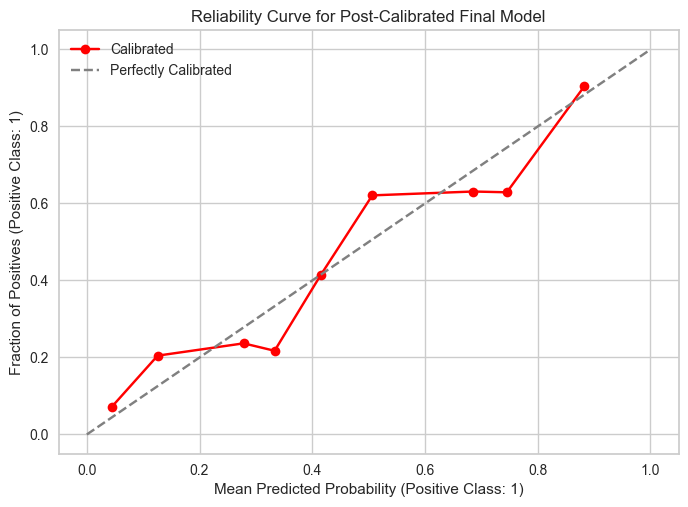

In [59]:
# calibration is applied on the validation set
X_val = val_nearmiss_set.drop(columns='Churn')
y_val = val_nearmiss_set.Churn

# calibrate the classifier using sigmoid method
calibrated_model = CalibratedClassifierCV(estimator=final_model, cv='prefit', method='isotonic')

# calibration process
calibrated_model.fit(X_val, y_val)

# predict probabilities on the test set
y_pred_proba = calibrated_model.predict_proba(X_test)[:, 1]

# compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# plot the calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', color='red', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)')
plt.ylabel('Fraction of Positives (Positive Class: 1)')
plt.title('Reliability Curve for Post-Calibrated Final Model')
plt.legend(loc='best')
plt.show()

**Key Takeaways** 

- The calibration curve for the post-calibrated final model demonstrates a significant improvement in aligning the predicted probabilities with the observed fraction of positives. The red line, representing the calibrated model, closely follows the dashed diagonal line of perfect calibration, particularly for mid-to-high probability ranges (0.4–1.0). This indicates that the model now provides reliable probabilistic predictions in these regions. For lower probability ranges (0.0–0.2), there is still a slight deviation, where the predicted probabilities slightly underestimate the observed fraction of positives. However, this discrepancy is minimal compared to the pre-calibration state, showcasing the effectiveness of the calibration process. 
- The overall alignment of the curve with the perfect calibration line reflects that the model is now well-calibrated, meaning its probability outputs are trustworthy for making decisions or threshold adjustments based on these probabilities. This improvement is particularly crucial for applications where accurate probability estimation is necessary for risk-based decisions.

### **5.2 Confusion Matrix & Cost-Saving Simulation: Uncalibrated vs Calibrated Model**

A confusion matrix displays how well a classification model is performing by showing the number of correct and incorrect predictions. It breaks down the results into four categories: true positives (correctly predicted positives), false positives (negatives incorrectly predicted as positives), true negatives (correctly predicted negatives), and false negatives (positives incorrectly predicted as negatives).

#### **5.2.1. Cost-saving simulation of uncalibrated model**

F5 Score: 0.815


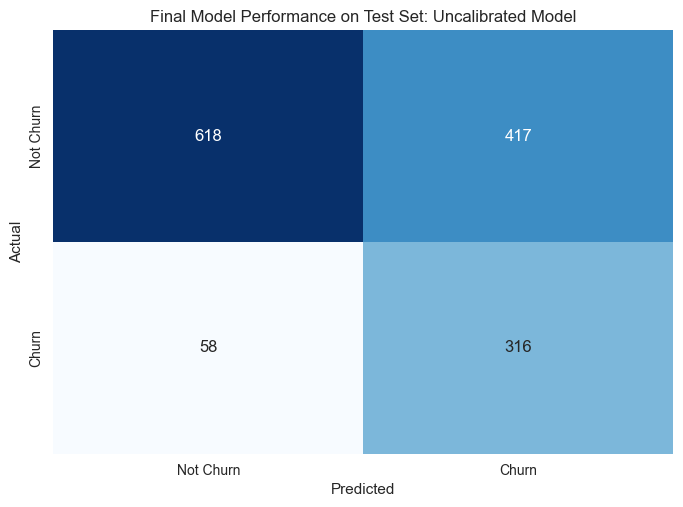

In [60]:
# predict on the test set
y_pred_test = final_model.predict(X_test)

# calculate F5 score
print(f"F5 Score: {fbeta_score(y_test, y_pred_test, beta=5).round(3)}")

# plot the confussion matrix
cm = confusion_matrix(y_test, y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Final Model Performance on Test Set: Uncalibrated Model')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

**Scenario 1: Customer churn without models**
- Before we calculate the misclassification costs of the best model using the confusion matrix, let's recap: the cost per false positive is USD138.8, and the cost per false negative is USD694.
- Without the model, there are 374 actual churns missed, resulting in $$374 \: \text{churns} \times \$694 = \$259,556$$

**Scenario 2: Customer churn with models**
- False positives (actual Not Churn, predicted Churn): $$417 \: \text{errors} \times \$138.8 = \$57,879.6$$
- False negatives (actual Churn, predicted Not Churn): $$58 \: \text{errors} \times \$694 = \$40,252$$
- In total, the financial cost to the company due to the model's misclassification is **USD98,131.6**
- Considering both scenarios, it means the model can save:
$$\$259,556 - \$98,131.6 = \$161,424.4$$

#### **5.2.2 Cost-saving simulation of calibrated model**

F5 Score: 0.491


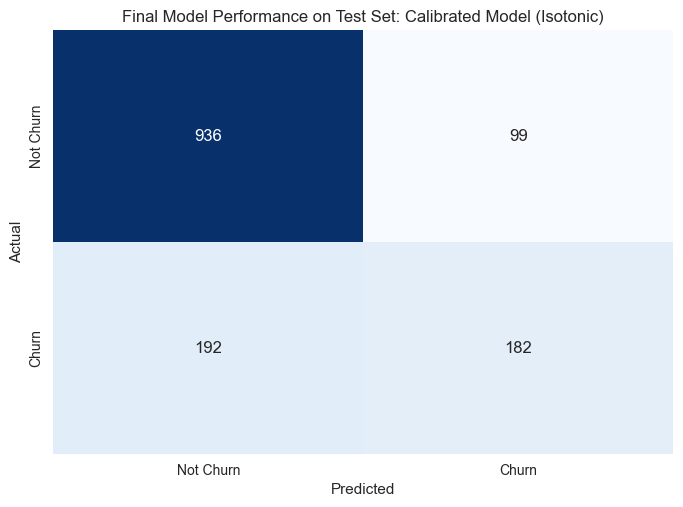

In [61]:
# predict on the test set
y_pred_test = calibrated_model.predict(X_test)

# calculate F5 score
print(f"F5 Score: {fbeta_score(y_test, y_pred_test, beta=5).round(3)}")

# plot the confussion matrix
cm = confusion_matrix(y_test, y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Final Model Performance on Test Set: Calibrated Model (Isotonic)')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

**Scenario 1: Customer churn without models**
- Without the model, there are 374 actual churns missed, resulting in $$374 \: \text{churns} \times \$694 = \$259,556$$

**Scenario 2: Customer churn with models** 
- False positives (actual Not Churn, predicted Churn): $$99 \: \text{errors} \times \$138.8 = \$13,741.2$$
- False negatives (actual Churn, predicted Not Churn): $$192 \: \text{errors} \times \$694 = \$133,248$$
- In total, the financial cost to the company due to the model's misclassification is **USD146,989.2**
- Considering both scenarios, it means the model can save:
$$\$259,556 - \$146,989.2 = \$112,566.8$$

**Financial impact consideration**

Based on the evaluation, the uncalibrated model outperformed the calibrated model in terms of F5 score (0.815 vs. 0.491) and loss cost (USD 98,131 vs. USD 146,989). Although the calibrated model achieved perfect calibration by aligning to the diagonal line, but, the significant decrease in the F5 score and the drastic increase in the loss cost indicate that the better probabilistic accuracy did not translate into better decision-making or cost optimization. The uncalibrated model, despite having high and low confidence levels, shows superior performance in minimizing the cost of loss, which is the main objective in this context. Therefore, the uncalibrated model should be chosen, as it achieves a better balance between model performance and financial impact.

And another consideration is that Logistic Regression theoretically produces well-calibrated probabilities, as the model is designed to maximize the likelihood of the data, so its predictions reflect the probability of the positive class. However, in practice, there are certain conditions where additional calibration is required. 

### **5.3 Global Explanation: SHAP Plot**

Since final model makes complex decisions based on numerous interactions between features, which can be hard to interpret directly, we use SHAP plot for getting the feature importance. This plot visualizes how much each feature contributes to the model's prediction based on game theory. By utilizing this plot, we can gain an understanding of the general behavior of the final model and show which features have the most significant impact (both positive or negative).

In [81]:
# apply preprocessing to get the transformed feature names
X_train_transformed = final_model[:-1].transform(df_seen.drop(columns=['customerID', 'Churn']))
X_test_transformed = final_model[:-1].transform(X_test)

# get feature names
unique_feature_names = X_test_transformed.columns

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(final_model[-1].predict_proba, X_train_transformed, link="identity")
shap_values = explainer.shap_values(X_test_transformed, nsamples=100)

Using 5634 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1409 [00:00<?, ?it/s]

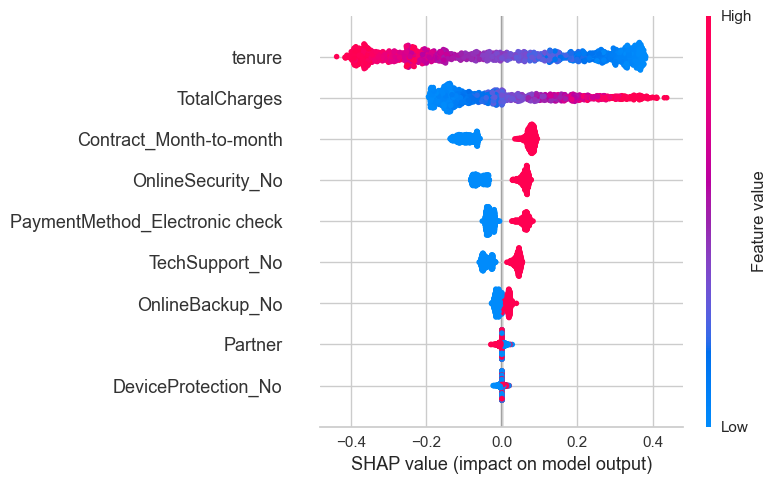

In [82]:
# visualize global feature importance
shap.summary_plot(shap_values[1], X_test_transformed, 
                  feature_names=unique_feature_names, 
                  title="SHAP Summary Plot",
                  plot_size=(8, 5))

**Key Takeaways**

This SHAP summary plot visualizes the impact of feature values on the model's output, with the x-axis representing the SHAP values (positive values push the model toward predicting churn, while negative values push it away from churn). Each dot corresponds to a single customer, with color indicating the feature value (red for high, blue for low). For example, higher tenure (blue) decreases the likelihood of churn, while lower tenure (red) increases it. In contrast, high TotalCharges (red) tend to increase churn probability. Features such as Contract_Month-to-month and missing OnlineSecurity or TechSupport significantly influence churn predictions, with high values (red) typically contributing to churn. This plot emphasizes the relationship between individual feature values and their contribution to churn prediction, enabling actionable insights for targeted interventions.

### **5.4 Local Explanation: Counterfactual**
To enhance the interpretability of our best-performing customer churn prediction model, we use counter factual explanation. Just a quick explanation, counterfactual explanation is a XAI method to understand a model's decision by showing how the outcome would change with different input data (see [Mothilal, Sharma, & Tan, 2020](https://arxiv.org/abs/1905.07697) for the introduction). It helps answer the question, "What if the input data were different?" This approach not only helps us understand the key drivers behind the model's predictions but also provides actionable insights for strategies to prevent customers from churning.

In [70]:
# specify numerical columns
cont_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# define the data interface
data_interface = dice_ml.Data(dataframe=df_seen.drop(columns='customerID'), continuous_features=cont_features, outcome_name='Churn')

# define the model interface
model_interface = dice_ml.Model(model=final_model, backend='sklearn')

# initialize Dice
dice = Dice(data_interface, model_interface)

Suppose there is one customer that the model predicts will churn with a probability of 0.63

In [71]:
# choose customer sample
cust_sample = X_test.loc[7025:7025, :]

# show prediction result
display(show_predict(final_model, cust_sample))

Original Outcome: 1


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,proba_0,proba_1
7025,Female,No,No,No,18,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.4,1,0.37,0.63


Here we exemplify intervening on two features, namely `Tenure` and `Total Charges`, based on the SHAP output. The selection of these two features is based on the features that are most likely to be intervened by the Customer Experience Manager, supported by the Marketing Manager, such as providing loyalty programs and targeted offers. 

**Simulating Tenure**

In [72]:
np.random.seed(42)
random.seed(42)

# generate counterfactuals
cf = dice.generate_counterfactuals(cust_sample, desired_class=0, total_CFs=3, features_to_vary=['tenure'])

# extract counterfactual instances
counterfactual_instances = cf.cf_examples_list[0].final_cfs_df

# predict probabilities for the counterfactuals
cf_probs = final_model.predict_proba(counterfactual_instances.drop(columns='Churn'))

# add predicted probabilities for class 1 and 0
counterfactual_instances['proba_0'] = cf_probs[:, 0].round(2)
counterfactual_instances['proba_1'] = cf_probs[:, 1].round(2)

# display output
counterfactual_instances

100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,proba_0,proba_1
0,Female,No,No,No,55,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.4,0,0.92,0.08
1,Female,No,No,No,70,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.4,0,0.98,0.02
2,Female,No,No,No,36,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.4,0,0.72,0.28


**Key Takeaways**
- The counterfactual explanation indicates that increasing the `Tenure` from 2 to higher values (e.g. 36, 55, and 70) would change the outcome from churn to not churn. This finding makes sense since previously we already discovered that churned customers usually have shorter tenure. This suggests that decresing tenure (customer's duration with the company) significantly influences the likelihood of churning.
- Based on this output, in order to encourage long-term customer retention, we can propose an idea to the Customer Experience Maneger to implement or enhance loyalty programs that reward loyal customers and provide personalized discounts or offers based on customer tenure, making them feel valued and appreciated.

**Simulating Total Charges**

In [73]:
np.random.seed(42)
random.seed(42)

# generate counterfactuals
cf = dice.generate_counterfactuals(cust_sample, desired_class=0, total_CFs=3, features_to_vary=['TotalCharges'])

# extract counterfactual instances
counterfactual_instances = cf.cf_examples_list[0].final_cfs_df

# predict probabilities for the counterfactuals
cf_probs = final_model.predict_proba(counterfactual_instances.drop(columns='Churn'))

# add predicted probabilities for class 1 and 0
counterfactual_instances['proba_0'] = cf_probs[:, 0].round(2)
counterfactual_instances['proba_1'] = cf_probs[:, 1].round(2)

# display output
counterfactual_instances

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,proba_0,proba_1
0,Female,No,No,No,18,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,659.6,0,0.54,0.46
1,Female,No,No,No,18,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,713.1,0,0.53,0.47
2,Female,No,No,No,18,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,316.4,0,0.60,0.40


**Key Takeaways**
- The counterfactual explanation indicates that decreasing the `Total Charges` from USD1679.4 to higher values (e.g. 316, 713, and 659) would change the outcome from churn to not churn. This finding makes sense since previously we already discovered that churned customers usually have high Total Charges. This suggests that increasing Total Charges significantly influences the likelihood of churning.
- Based on this output, in order to encourage long-term customer retention, we can propose an idea to the Customer Experience Maneger to implement pricing plans programs or loyalty discounts, making them satisfaction with perceived high costs.

### **5.5 Churn Reduction Simulation**
In order this churn reduction simulation to work using the model, we need several assumptions: (1) The model has been deployed in the production environment and used by the CX Manager to predict customer churns. (2) The Customer Experience Manager with the support of Marketing Manager already carried out an intrvention to at-risk customers with retention success rate at 50%.

And now, let us break down the logic of the calculation which we will implement it on the function below:
1. Calculate the current churned customers. The churn rate can be adjusted to the rate in which another simulation is done. But for a starting point, let's use the churn rate based on the EDA, i.e., 26.5%. 
$$\text{current churners} = \text{total customers} \times \text{churn rate}$$
2. Calculate the number of churners to retain. This number of customers is obtained from the model's predictions and multiplied by the success rate of the stakeholder's intervention. For example, the stakeholder runs targeted intervention to the at-risk customers (those predicted as churn by the model). 
$$\text{retained churners} = \text{predicted churners} \times \text{retention success rate}$$
3. Calculate the number of new churners. This number is based on the total of current churners substrated by the retained ones. 
$$\text{new churners} = \text{current churners} - \text{retained churners}$$ 
4. Calculate new churn rate by dividing new churners from total customers. $$\text{new churn rate} = \frac{\text{new churners}}{\text{total customers}}$$

In [74]:
# build function for the simulation
def simulate_churn_reduction(total_customers, current_churn_rate, predicted_churners, retention_success_rate):
    current_churners = total_customers * current_churn_rate
    retained_churners = predicted_churners * retention_success_rate
    new_churners = current_churners - retained_churners
    new_churn_rate = new_churners / total_customers
    return new_churn_rate

# assumptions
total_customers = 10000
current_churn_rate = 0.265
predicted_churners = 1600
retention_success_rate = 0.5

# perform simulation
new_churn_rate = simulate_churn_reduction(total_customers, current_churn_rate, predicted_churners, retention_success_rate)
print(f"New Churn Rate: {new_churn_rate * 100:.2f}%")

New Churn Rate: 18.50%


**Key Takeaways**
- Based on the assumptions, the model has been used to predict 10,000 customers, and there are 1,600 users susceptible to churn so the CX Manager implemented a targeted intervention, i.e., offerring 10% cashback with certain max valuee for the customer's next purchase. This marketing startegy is assumed to have 50% success rate.
- From this point, the churn rate will be 18.50%, or a reduction of about 8%, slightly below the target of 10%. 

### **5.6 Model Saving**

In the lifecycle of a machine learning project, model saving allows you to store the trained model in a file format that can be loaded and deployed later for inference, evaluation, or further training. This process not only saves time by eliminating the need to retrain the model from scratch but also facilitates seamless integration into production systems or applications.

In [75]:
import joblib 

# save model
joblib.dump(final_model, '../model/clf_final.pkl')

['../model/clf_final.pkl']

<a href="#top" style="display: inline-block; padding: 10px; text-decoration: none; background-color: #007bff; color: white; border-radius: 5px; margin-top: 20px;">Back to Top</a>